## Analyse von Phyphox Daten

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series
import numpy as np
from scipy import signal 
import os
%matplotlib ipympl
plt.close()

In [127]:
# Einlesen der Messdaten
working_dir = "/Users/dirkm/Documents/Github/python_experiments"
os.chdir(working_dir)
new_dir = os.getcwd()
#
print("New current working directory:", new_dir)
#experiment_dir = "2024-08-10_16-01-40"
#experiment_dir = "2024-08-10_19-22-24"
experiment_dir = "2024-08-10_20-04-53"
#data_dir = working_dir + "/Beschleunigung ohne g " + experiment_dir
data_dir = working_dir + "/My Experiment " + experiment_dir
os.chdir(data_dir)
new_dir = os.getcwd()
print("New current working directory:", new_dir)
#testdata = pd.read_csv("Raw data.csv") 
# Einlesen der Beschleunigungsdaten
testdata = pd.read_csv("Accelerometer.csv") 
print(testdata.head())
#df1 = testdata.rename(columns={"Time (s)": "t", "Linear Acceleration x (m/s^2)" : "x", "Linear Acceleration y (m/s^2)" : "y", "Linear Acceleration z (m/s^2)" : "z" })
df1 = testdata.rename(columns={"Time (s)": "t", "Acceleration x (m/s^2)" : "x", "Acceleration y (m/s^2)" : "y", "Acceleration z (m/s^2)" : "z" })
#Einlesen der Gyroskopdaten
testdata = pd.read_csv("Gyroscope.csv") 
print(testdata.head())
df2 = testdata.rename(columns={"Time (s)": "t", "Gyroscope x (rad/s)" : "gx", "Gyroscope y (rad/s)" : "gy", "Gyroscope z (rad/s)" : "gz" })


New current working directory: C:\Users\dirkm\Documents\Github\python_experiments
New current working directory: C:\Users\dirkm\Documents\Github\python_experiments\My Experiment 2024-08-10_20-04-53
   Time (s)  Acceleration x (m/s^2)  Acceleration y (m/s^2)  \
0  0.048644               -0.269608                9.614136   
1  0.053680               -0.280762                9.609680   
2  0.058715               -0.281219                9.613083   
3  0.063751               -0.257751                9.634079   
4  0.068786               -0.250702                9.632156   

   Acceleration z (m/s^2)  
0               -7.039734  
1               -7.052017  
2               -7.061264  
3               -7.063721  
4               -7.066193  
   Time (s)  Gyroscope x (rad/s)  Gyroscope y (rad/s)  Gyroscope z (rad/s)
0  0.401122             0.001175             0.000412            -0.001053
1  0.406158             0.000427            -0.000336            -0.001953
2  0.411193             0.0011

In [128]:
# Zusammenfassen in 1 Pandas Data Frame
mergedData = pd.merge_asof(df1, df2, on='t', direction='backward')

In [129]:
print(mergedData.head()) 

          t         x         y         z  gx  gy  gz
0  0.048644 -0.269608  9.614136 -7.039734 NaN NaN NaN
1  0.053680 -0.280762  9.609680 -7.052017 NaN NaN NaN
2  0.058715 -0.281219  9.613083 -7.061264 NaN NaN NaN
3  0.063751 -0.257751  9.634079 -7.063721 NaN NaN NaN
4  0.068786 -0.250702  9.632156 -7.066193 NaN NaN NaN


<Axes: xlabel='t'>

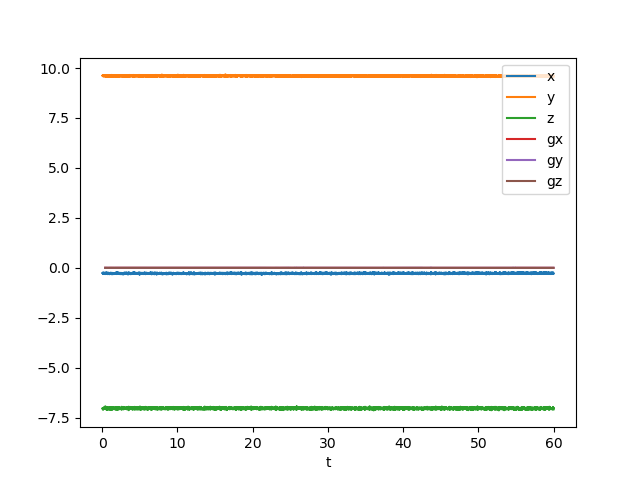

In [130]:
mergedData.plot(x="t")

In [131]:
#Entfernen der Zeilen mit fehlenden Sensordaten
df = mergedData.dropna(ignore_index = True).copy()

In [132]:
# Korrektur / Kalibrierung des Accelerometers z Achse
# Sensor aufrecht liegend: 
z_plus = 1.65
# Sensor umgekehrt liegend:
z_minus = -18.08

# lineare Umrechnung z_korr = a z + b
g = 9.81
a = 2*g/(z_plus - z_minus)
b = - g * (z_minus + z_plus)/(z_plus - z_minus)

zk = a * df.z  + b

df['zk'] = zk
# df['zk'] = df.apply(lambda row: a * row.z + b, axis = 1)

<Axes: xlabel='t'>

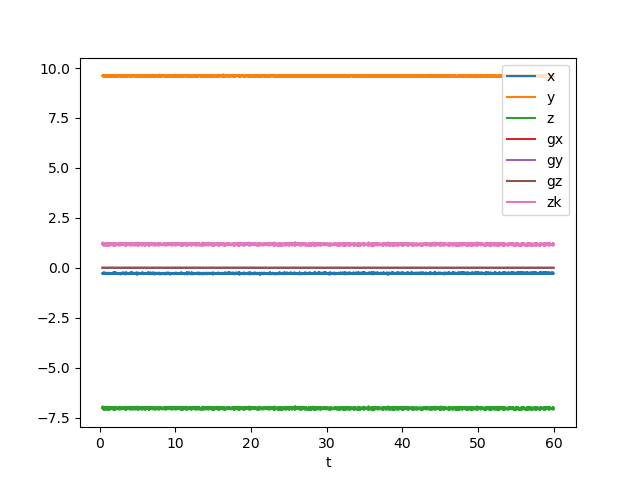

In [133]:
df.plot(x="t")

In [134]:
# Einlesen von Daten aus der Simulation
#data_dir = working_dir 
#os.chdir(data_dir)
#new_dir = os.getcwd()
#testdata = pd.read_csv("pendulum_data.csv") 
#print(testdata.head())
#df = testdata.rename(columns={"time":"t", "theta_noisy":"tn", "theta":"tx", "theta_dot":"txd"})
#print(df.head())

In [135]:
#df.plot("t","tx", grid=True, xlabel = "t [s]", ylabel = "theta_x [rad]", title="Zeitreihe Neigung")
#df.plot("t","txd", grid=True, xlabel = "t [s]", ylabel = "theta_x_dot [rad]")

In [136]:
# Abtastintervall
dt = df.t[1] - df.t[0]
fs = 1/dt
print(fs)

198.59395480001498


In [137]:
f, PXX = signal.periodogram(df.gx, fs)
#f, PYY = signal.periodogram(df.ty, fs)
#f, PZZ = signal.periodogram(df.tz, fs)

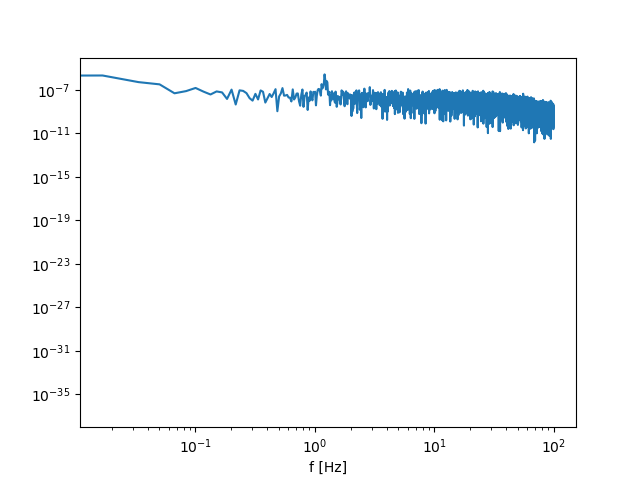

In [138]:
plt.figure()
plt.loglog(f, PXX)
#plt.loglog(f, PYY)
#plt.loglog(f, PZZ)
plt.xlabel("f [Hz]")
plt.show()

In [139]:
# Funktionen für die Kalman Filterung 

In [140]:
X = np.array([0.0]) # Zustand: Auslenkung 
A = np.array([[1.0]]) # Übergangsmatrix 
H = np.array([[1.0]]) # Messung der Auslenkung -> vor dem Einsetzen von Y aus dem Drehwinkel berechnen berechnen
R = np.array([[1.0]])*5
P = np.array([[1.0]])
Q = np.array([[0.1]])
U = 0 # Eingangsgröße Drehwinkelrate (Anfangswert)
B = np.array([dt])

In [141]:
def kf_predict(X, P, A, Q, B, U):
    X = np.dot(A, X) + np.dot(B, U)
    P = np.dot(A, np.dot(P, A.T)) + Q
    return(X,P)

In [142]:
def kf_update(X, P, Y, H, R):
    IM = np.dot(H, X)
    IS = R + np.dot(H, np.dot(P, H.T))
    K = np.dot(P, np.dot(H.T, np.linalg.inv(IS)))
    X = X + np.dot(K, (Y-IM))
    P = P - np.dot(K, np.dot(IS, K.T))
    LH = gauss_pdf(Y, IM, IS)
    return (X,P,K,IM,IS,LH)

In [143]:
def gauss_pdf(X, M, S):
    if np.shape(M)[0] == 1:
        DX = X - np.tile(M, np.shape(X)[1])
        E = 0.5 * np.sum(DX * (np.dot(np.linalg.inv(S), DX)), axis=0)
        E = E + 0.5 * np.shape(M)[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    elif np.shape(X)[0] == 1:
        DX = np.tile(X, M.shape()[1])- M
        E = 0.5 * np.sum(DX * (np.dot(np.linalg.inv(S), DX)), axis=0)
        E = E + 0.5 * np.shape(M)[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    else:
        DX = X-M
        E = 0.5 * np.dot(DX.T, np.dot(np.linalg.inv(S), DX))
        E = E + 0.5 * np.shape(M)[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    return (P[0],E[0])

In [144]:
# Zeitreihen aus der Simulation
#thx = df.tn
#thxd = df.txd
#t = df.t

In [145]:
# Zeitreihen aus der Messung
thx = df.zk/df.y # Näherungsweise: Drehwinkel als Verhältnis der Beschleunigungswerte
thxd = df.gx # Drehrate vom Gyroskop
t = df.t

In [146]:
n = 0
thx_e = np.zeros_like(thx)
kalman_gain = np.zeros_like(thx)

In [147]:
# Iterieren über die Zeitreihe
while n < len(thx):
    U = np.array([[thxd[n]]])
    (X, P) = kf_predict(X, P, A, Q, B, U)
    Y = np.array([[thx[n]]])
    (X, P, K, IM, IS, LH) = kf_update(X, P, Y, H, R)
    thx_e[n] = np.ndarray.item(X, 0)
    kalman_gain[n] = np.ndarray.item(K, 0)
    n += 1 

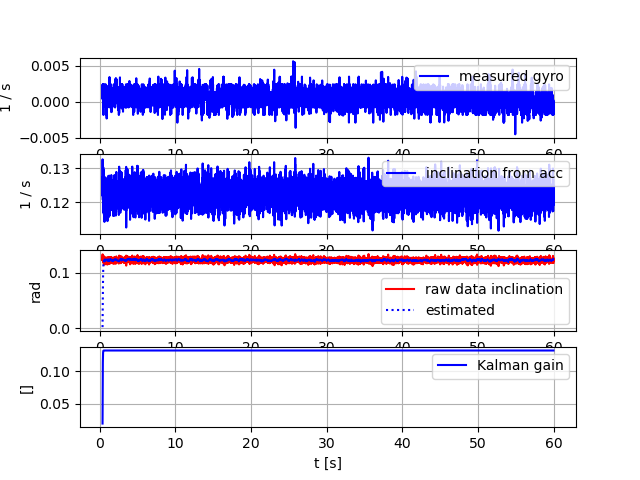

In [148]:
plt.figure()

plt.subplot(4,1,1)
plt.plot(t, thxd, 'b', label = "measured gyro")
plt.xlabel("t [s]")
plt.ylabel("rad / s")
plt.grid()
plt.legend()
#

plt.subplot(4,1,2)
plt.plot(t, thx, 'b', label = "inclination from acc")
plt.xlabel("t [s]")
plt.ylabel("rad")
plt.grid()
plt.legend()

plt.subplot(4,1,3)
plt.plot(t, thx, 'r', label = "raw data inclination")
plt.plot(t, thx_e, 'b:', label = "estimated")
# plt.plot(t, df.tx, 'k--', label = 'ground truth') # nur für die Simulation
plt.xlabel("t [s]")
plt.ylabel("rad")
plt.grid()
plt.legend()

plt.subplot(4,1,4)
plt.plot(t, kalman_gain, 'b', label = "Kalman gain")
plt.xlabel("t [s]")
plt.ylabel("[]")
plt.grid()
plt.legend()


plt.show()

In [149]:
# Auslenkung aus der Inklination des Sensors
l = 1
z = thx_e*l

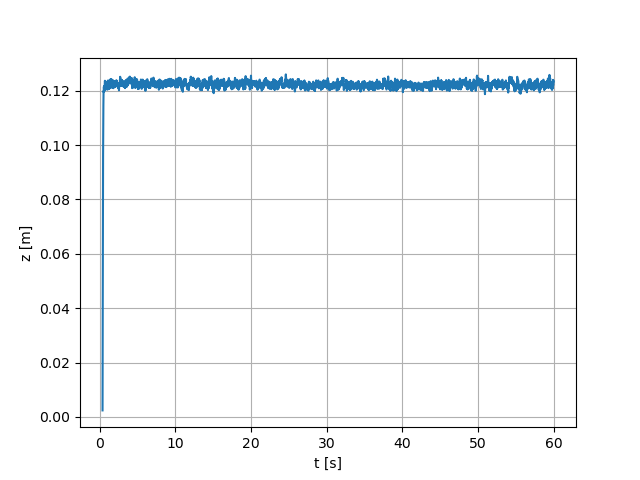

In [162]:
plt.figure()
plt.plot(t, z)
plt.xlabel('t [s]')
plt.ylabel('z [m]')
plt.grid()
plt.show()

In [161]:
f, PXX = signal.periodogram(z, fs)
#f, PYY = signal.periodogram(df.ty, fs)
#f, PZZ = signal.periodogram(df.tz, fs)

### Zum Vergleich: Integration der Drehrate

In [151]:
thx_i = np.zeros_like(thxd)

In [157]:
for n in range(len(thxd)-1):
    thx_i[n+1] = thx_i[n] + dt * thx[n]

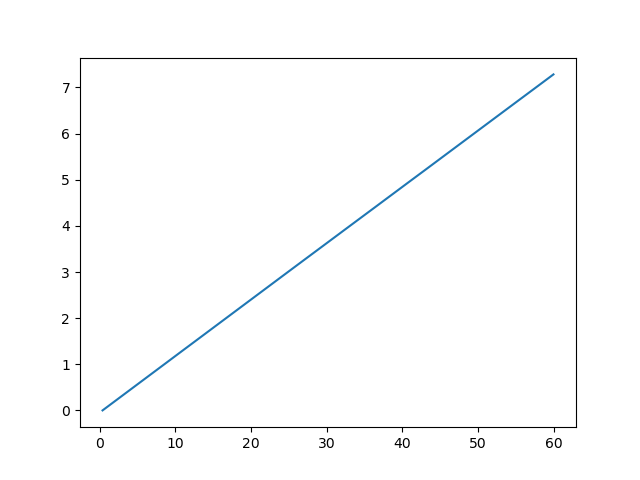

In [159]:
plt.figure()
plt.plot(t,thx_i)